In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.utils.vis_utils import plot_model
import sklearn
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import math
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
#from tensorflow import set_random_seed
from numpy.random import seed
#set_random_seed(1)
seed(1)

train = pd.read_csv('../data/newTrainset_MW.csv',',')

train.describe()

,Lateness,Assembly,Material,OpenOrders,NewOrders,TotalWork,TotalSetup,SumDuration,SumOperations,ProductionOrders,CycleTime
count,6587.000000,6587.000000,6.587000e+03,6587.000000,6587.000000,6587.000000,6587.000000,6587.000000,6587.00000,6587.000000,6587.000000
mean,-1711.499227,197.265912,1.630194e+09,11.793381,1.868529,4.404652,9.177828,220.625626,22.01002,4.402004,2757.461971
std,189.376457,89.824216,7.455956e+08,3.239967,1.366720,1.511232,2.517762,74.597966,7.47795,1.495590,994.280850
min,-2844.000000,8.120536,5.397321e+07,2.000000,0.000000,0.000000,0.000000,135.000000,15.00000,3.000000,1353.000000
25%,-1828.984000,121.824400,1.014070e+09,10.000000,1.000000,3.490000,7.995000,153.000000,15.00000,3.000000,1968.500000
50%,-1697.129800,209.683870,1.724483e+09,12.000000,2.000000,4.530000,9.910000,199.000000,20.00000,4.000000,2521.000000
75%,-1611.983500,273.060740,2.254657e+09,14.000000,3.000000,5.470000,11.000000,261.000000,25.00000,5.000000,3427.000000
max,-644.250000,393.516050,3.205616e+09,27.000000,9.000000,8.800000,13.290000,458.000000,45.00000,9.000000,6817.000000


In [2]:
train

,Lateness,Assembly,Material,OpenOrders,NewOrders,TotalWork,TotalSetup,SumDuration,SumOperations,ProductionOrders,CycleTime
0,-1393.0000,22.948214,2.267202e+08,15,3,6.00,10.54,357,35,7,3826
1,-1465.2858,33.055325,2.787615e+08,16,0,5.40,11.05,192,20,4,2068
2,-1517.0000,38.106250,3.069545e+08,12,0,5.35,10.88,296,30,6,4109
3,-1448.2354,42.731410,4.160865e+08,12,0,5.36,12.07,297,30,6,3599
4,-1431.8889,49.299152,3.960410e+08,12,1,4.26,8.88,264,25,5,3775
...,...,...,...,...,...,...,...,...,...,...,...
6582,-1764.1119,345.123660,2.865520e+09,15,1,4.52,10.42,198,20,4,2313
6583,-1768.2643,345.343660,2.852534e+09,15,3,2.75,5.35,154,15,3,2042
6584,-1774.1343,345.276700,2.896368e+09,16,4,4.44,9.42,347,35,7,3546
6585,-1773.7039,347.674400,2.907367e+09,16,4,5.57,10.23,252,25,5,2903


In [3]:
split_fraction = 0.70
train_split = int(split_fraction * int(train.shape[0]))
step = 1

#past = 0
#future = 8
learning_rate = 0.0005
batch = 32
epochs = 100
mean = 0
std = 0

def normalize(data, train_split):
    global mean
    global std
    data_mean = data[:train_split].mean(axis=0)
    mean = data_mean
    data_std = data[:train_split].std(axis=0)
    std = data_std
    return (data - data_mean) / data_std

In [4]:
titles = ['Lateness',
          'Assembly',
          'Material',
          'OpenOrders',
          'NewOrders',
          'TotalWork',
          'TotalSetup',
          'SumDuration',
          'SumOperations',
          'ProductionOrders',
          'CycleTime']
#  
# for c in train.columns:
#     titles.append(c);
    
features = train[titles]
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

,0,1,2,3,4,5,6,7,8,9,10
0,1.713869,-1.932109,-1.871582,0.987092,0.840165,1.042386,0.530171,1.800421,1.708768,1.708768,1.069393
1,1.317145,-1.820749,-1.802578,1.298961,-1.378987,0.642955,0.735354,-0.389740,-0.276469,-0.276469,-0.698155
2,1.033323,-1.765098,-1.765196,0.051482,-1.378987,0.609669,0.666960,0.990725,1.047022,1.047022,1.353930
3,1.410722,-1.714138,-1.620493,0.051482,-1.378987,0.616326,1.145721,1.003999,1.047022,1.047022,0.841160
4,1.500436,-1.641775,-1.647072,0.051482,-0.639270,-0.115965,-0.137681,0.565966,0.385277,0.385277,1.018116


In [5]:
train_data = features.loc[0 : train_split - 1] #Training Data
val_data = features.loc[train_split:] #Validation Data
train_data

,0,1,2,3,4,5,6,7,8,9,10
0,1.713869,-1.932109,-1.871582,0.987092,0.840165,1.042386,0.530171,1.800421,1.708768,1.708768,1.069393
1,1.317145,-1.820749,-1.802578,1.298961,-1.378987,0.642955,0.735354,-0.389740,-0.276469,-0.276469,-0.698155
2,1.033323,-1.765098,-1.765196,0.051482,-1.378987,0.609669,0.666960,0.990725,1.047022,1.047022,1.353930
3,1.410722,-1.714138,-1.620493,0.051482,-1.378987,0.616326,1.145721,1.003999,1.047022,1.047022,0.841160
4,1.500436,-1.641775,-1.647072,0.051482,-0.639270,-0.115965,-0.137681,0.565966,0.385277,0.385277,1.018116
...,...,...,...,...,...,...,...,...,...,...,...
4605,0.709515,-1.803988,-1.796090,0.675222,-1.378987,1.002443,0.087619,-0.973783,-0.938215,-0.938215,-1.272256
4606,1.236389,-1.797512,-1.820485,0.363352,-0.639270,0.010522,0.699146,3.141065,3.032259,3.032259,3.696585
4607,1.276637,-1.769668,-1.735857,-0.572257,0.100447,0.150323,1.198023,-0.894141,-0.938215,-0.938215,-0.813779
4608,1.276637,-1.731876,-1.701831,0.051482,0.100447,0.642955,0.723285,-0.323372,-0.276469,-0.276469,-0.430710


In [6]:
#start = past + future
start = 0
end = start + train_split

x_train = train_data[[i for i in range(len(titles) - 1)]].values
y_train = features.iloc[start:end][[len(titles)-1]]

#sequence_length = int(past / step)
sequence_length = 1
x_train[0]

array([ 1.71386882, -1.93210931, -1.87158201,  0.98709156,  0.84016457,
        1.04238598,  0.53017102,  1.80042083,  1.708768  ,  1.708768  ])

In [7]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch
)

In [8]:
label_start = train_split
valRange = int(train.shape[0]) - train_split

# x_val = val_data.iloc[[i for i in range(valRange)]].values
x_val = val_data[[i for i in range(len(titles) - 1)]].values
# x_val = val_data.iloc[[i for i in range(49)]].values
y_val = features.iloc[label_start:][[len(titles)-1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch
)

for batch in dataset_train.take(1):
    inputs, targets = batch
print(x_val)
print(y_val)
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)
print(inputs)

[[ 0.77894126 -1.66761713 -1.60957378 ... -0.84104598 -0.93821469
  -0.93821469]
 [ 0.60079407 -1.61730137 -1.59510889 ...  0.30049244  0.38527665
   0.38527665]
 [ 0.4537138  -1.60801758 -1.56742126 ...  0.49959798  0.38527665
   0.38527665]
 ...
 [-0.37790083  1.61929937  1.66822278 ...  1.6676838   1.708768
   1.708768  ]
 [-0.37553868  1.64571718  1.68280698 ...  0.40668206  0.38527665
   0.38527665]
 [-0.3908367   1.66474523  1.70621892 ... -0.36319269 -0.27646902
  -0.27646902]]
            10
4610 -0.914323
4611  0.342466
4612  0.392738
4613  0.115239
4614 -0.840926
...        ...
6582 -0.451824
6583 -0.724296
6584  0.787872
6585  0.141380
6586 -0.662965

[1977 rows x 1 columns]
Input shape: (32, 1, 10)
Target shape: (32, 1)
tf.Tensor(
[[[ 1.71386882 -1.93210931 -1.87158201  0.98709156  0.84016457
    1.04238598  0.53017102  1.80042083  1.708768    1.708768  ]]

 [[ 1.3171445  -1.82074936 -1.80257808  1.29896135 -1.3789867
    0.64295459  0.73535442 -0.38974009 -0.27646902 -0.27

In [9]:
# Long Short Term Memory - Model als Methodik mit Adam --> stochastic gradient descent algorithm

inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
#dropout1 = keras.layers.Dropout(0.4)(inputs)
hidden1 = keras.layers.LSTM(10, return_sequences=True)(inputs)
hidden2 = keras.layers.LSTM(10)(hidden1)
#dropout2 = keras.layers.Dropout(0.4)(hidden1)
outputs = keras.layers.Dense(1, activation='tanh')(hidden2)
learning_rate = 0.001
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.99), loss=keras.losses.MeanSquaredError()) #metrics=keras.metrics.MeanAbsoluteError())
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
model.save("kerasModel")

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 10)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 10)             840       
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 1,691
Trainable params: 1,691
Non-trainable params: 0
_________________________________________________________________
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
INFO:tensorflow:Assets written to: kerasModel\assets
INFO:tensorflow:Assets written to:

In [13]:
path_checkpoint = "kerasModel/simpleModelCheckpoint.h5"

def scheduler(epoch, lr):
    return 0.01
    if lr > 0.004:
        return lr - 0.0002
    else:
        if lr > 0.0004:
            return lr - 0.000001
        else:            
            return 0.0001

es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=10)

lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True
)

epochs = 4000

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback,modelckpt_callback, lr_scheduler]
)

Epoch 1/4000

Epoch 00001: LearningRateScheduler reducing learning rate to 0.01.
145/145 [==============================] - 1s 6ms/step - loss: 0.2220 - val_loss: 0.2360

Epoch 00001: val_loss improved from inf to 0.23601, saving model to kerasModel\simpleModelCheckpoint.h5
Epoch 2/4000

Epoch 00002: LearningRateScheduler reducing learning rate to 0.01.
145/145 [==============================] - 0s 3ms/step - loss: 0.2218 - val_loss: 0.2355

Epoch 00002: val_loss improved from 0.23601 to 0.23546, saving model to kerasModel\simpleModelCheckpoint.h5
Epoch 3/4000

Epoch 00003: LearningRateScheduler reducing learning rate to 0.01.
145/145 [==============================] - 0s 3ms/step - loss: 0.2215 - val_loss: 0.2353

Epoch 00003: val_loss improved from 0.23546 to 0.23525, saving model to kerasModel\simpleModelCheckpoint.h5
Epoch 4/4000

Epoch 00004: LearningRateScheduler reducing learning rate to 0.01.
145/145 [==============================] - 0s 3ms/step - loss: 0.2212 - val_loss: 0.23

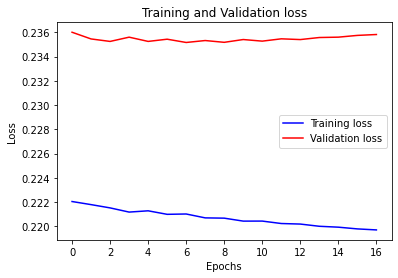

In [14]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    
visualize_loss(history, "Training and Validation loss")

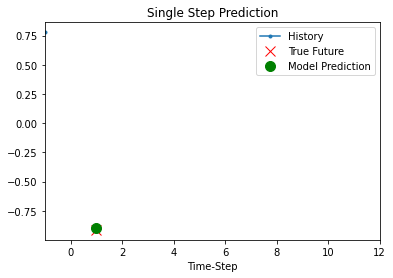

In [15]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

for x, y in dataset_val.take(1):
    show_plot(
        [x[0][:, 0].numpy(), y[0].numpy(), model.predict(x)[0]],
        1,
        "Single Step Prediction",
    )

In [16]:
def denormalize(value):
    data_mean = mean[len(titles)-1]
    data_std = std[len(titles)-1]
    return value*data_std+data_mean

for x, y in dataset_val.take(10):
    predictionData = model.predict(x)
    denormalized_predictionData = denormalize(predictionData)[0]
    actualValue = y[0].numpy()
    print("predicted denormalized:", denormalized_predictionData)
    print("   actual denormalized:", denormalize(actualValue))
    print("             predicted:", predictionData[0])
    print("                actual:", actualValue)

# for x, y in datasetPredTest.take(1):
#     show_plot(
#         [x[0][:, 0].numpy(), y[0].numpy(), model.predict(x)[0]],
#         1,
#         "Single Step Prediction",
#     )

predicted denormalized: [1867.2628]
   actual denormalized: [1853.]
             predicted: [-0.8999823]
                actual: [-0.91432255]
predicted denormalized: [3756.883]
   actual denormalized: [3860.]
             predicted: [0.9999009]
                actual: [1.10357785]
predicted denormalized: [1874.4211]
   actual denormalized: [1661.]
             predicted: [-0.89278513]
                actual: [-1.10736534]
predicted denormalized: [1818.3796]
   actual denormalized: [2120.]
             predicted: [-0.949131]
                actual: [-0.64587242]
predicted denormalized: [1859.7563]
   actual denormalized: [1556.]
             predicted: [-0.9075296]
                actual: [-1.21293562]
predicted denormalized: [3043.0752]
   actual denormalized: [3631.]
             predicted: [0.2822162]
                actual: [0.87333411]
predicted denormalized: [3207.9595]
   actual denormalized: [3702.]
             predicted: [0.44799602]
                actual: [0.94471973]
predi

In [18]:
def normalize(data):
    return (data - mean) / std

predTest = pd.read_csv('TestData/testData1.csv',';')
mean = train[titles].values.mean(axis=0)
std = train[titles].values.std(axis=0)
featuresPredTest = predTest[titles]
predTestRange = int(featuresPredTest.shape[0])
featuresPredTest = normalize(featuresPredTest.values)
featuresPredTest = pd.DataFrame(featuresPredTest)
x_predTest = featuresPredTest[[i for i in range(7)]].values
y_predTest = featuresPredTest.iloc[0:][[7]]

datasetPredTest = keras.preprocessing.timeseries_dataset_from_array(
    x_predTest,
    y_predTest,
    sequence_length=1,
    sampling_rate=1,
    batch_size=1
)

for x, y in datasetPredTest.take(10):
    predictionData = model.predict(x)
    denormalized_predictionData = denormalize(predictionData)
    print("predicted denormalized:", denormalized_predictionData)
    print("             predicted:", predictionData)
    print("                actual:", y[0].numpy())

FileNotFoundError: [Errno 2] No such file or directory: 'TestData/testData1.csv'

In [ ]:
# for x,y in datasetPredTest.take(2):
#     print(x[0][0].numpy(
normalize(featuresPredTest.values)

In [24]:
cc=denormalize(0.4095)
cc2=denormalize(0)
print(cc, cc2)
print(cc2 - cc)

3169.671454078709 2762.383514099783
-407.2879399789258


In [ ]:
x_train

In [ ]:
x_train.shape

In [ ]:
y_train

In [ ]:
y_train.shape

In [ ]:
mean

In [ ]:
std

In [ ]:
train[titles].values.mean(axis=0)

In [ ]:
test = [[[3.96250010e+00, 5.92916600e+07, 7.00000000e+00, 7.00000000e+00, 4.53000021e+00, 1.08999996e+01, 1.99000000e+02, 2.00000000e+01, 4.00000000e+00, 0.00000000e+00]]]

In [ ]:
test

In [ ]:
(test-train[titles].values.mean(axis=0))/train[titles].values.std(axis=0)

In [ ]:
train[titles].values.mean(axis=0)

In [ ]:
train[titles].values.std(axis=0)

In [ ]:
targets

In [ ]:
train_data.shape

In [14]:
y_val.values

array([[ 1.18080767],
       [ 0.19404747],
       [ 0.36203571],
       ...,
       [-0.93475157],
       [-0.51751248],
       [-0.90675353]])

In [13]:
x_val.shape

(52895, 7)